**Data Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import glob
import os
import requests
import time
import unicodedata
import re
import glob
import joblib
import pickle

In [ ]:
API_KEY = 'googlemapsapikey'
OWM_API_KEY = 'openweathermapsapikey'

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return None
    text = str(text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'[\r\n\t]', ' ', text)
    text = re.sub(r'[^\x20-\x7E]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().title()

# Load the dataset
file_path = '/content/data'
csv_files = glob.glob(os.path.join(file_path, '*.csv'))

df_list = []
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(file, encoding='ISO-8859-1')

    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(clean_text)

    df_list.append(df)

df = pd.concat(df_list, ignore_index=True, sort=False)

In [ ]:
def get_lat_lng(address, api_key):
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'
    params = {'address': address, 'key': api_key}
    response = requests.get(base_url, params=params).json()

    if response['status'] == 'OK':
        location = response['results'][0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        print(f"Failed to fetch: {address} | Status: {response['status']}")
        return None, None

# Combine Monitoring Location + State to form a full address
df['full_address'] = df['Monitoring Location'] + ', ' + df['State'] + ', India'

# Prepare new columns
df['Latitude'] = None
df['Longitude'] = None

# Use a dictionary to cache results and avoid redundant API calls
address_cache = {}

# Loop through each unique address
for address in df['full_address'].unique():
    if address not in address_cache:
        lat, lng = get_lat_lng(address, API_KEY)
        address_cache[address] = (lat, lng)
        time.sleep(0.2)  # Respect Google API rate limits

# Map cached coordinates back to the original DataFrame
df['Latitude'] = df['full_address'].map(lambda x: address_cache.get(x, (None, None))[0])
df['Longitude'] = df['full_address'].map(lambda x: address_cache.get(x, (None, None))[1])

# Save the updated DataFrame
# df.to_csv('WQuality_with_Coordinates.csv', index=False)
# print("Coordinates added and saved to 'WQuality_with_Coordinates.csv'")

KeyboardInterrupt: 

In [ ]:
def get_avg_weather(lat, lon, api_key):
    url = f"https://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    response = requests.get(url, params=params).json()

    if response['cod'] == 200:
        return {
            'Avg_Temp': response['main']['temp'],
            'Avg_Humidity': response['main']['humidity'],
            'Avg_Wind': response['wind']['speed'],
            'Weather_Main': response['weather'][0]['main']
        }
    else:
        print(f"Failed to fetch weather for {lat}, {lon} | Status: {response.get('message')}")
        return {
            'Avg_Temp': None,
            'Avg_Humidity': None,
            'Avg_Wind': None,
            'Weather_Main': None
        }


In [ ]:
weather_cache = {}

for index, row in df.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']

    if pd.notnull(lat) and pd.notnull(lon):
        key = (lat, lon)
        if key not in weather_cache:
            weather_data = get_avg_weather(lat, lon, OWM_API_KEY)
            weather_cache[key] = weather_data
        else:
            weather_data = weather_cache[key]

        df.at[index, 'Avg_Temp'] = weather_data['Avg_Temp']
        df.at[index, 'Avg_Humidity'] = weather_data['Avg_Humidity']
        df.at[index, 'Avg_Wind'] = weather_data['Avg_Wind']
        df.at[index, 'Weather_Main'] = weather_data['Weather_Main']

In [ ]:
df.to_csv('WQuality_with_Coordinates_Weather.csv', index=False)

NameError: name 'df' is not defined

loading csv file with coordinates and weather data

In [ ]:
try:
  df = pd.read_csv("/content/WQuality_with_Coordinates_Weather_2023.csv", encoding='utf-8')
except UnicodeDecodeError:
  df = pd.read_csv("/content/WQuality_with_Coordinates_Weather_2023.csv", encoding='ISO-8859-1')


**Adding Regions For Clustering**

In [ ]:
coord_df=df[['Latitude','Longitude']].dropna()

#use silhouette score to decide optimal number of clusters
def silhouette_scores_by_k(data, k_range):
    scores = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(data)
        # Silhouette not defined for 1 or for n >= n_samples
        if len(np.unique(labels)) > 1 and len(np.unique(labels)) < len(data):
            score = silhouette_score(data, labels)
            scores.append(score)
        else:
            scores.append(-1)
    return scores

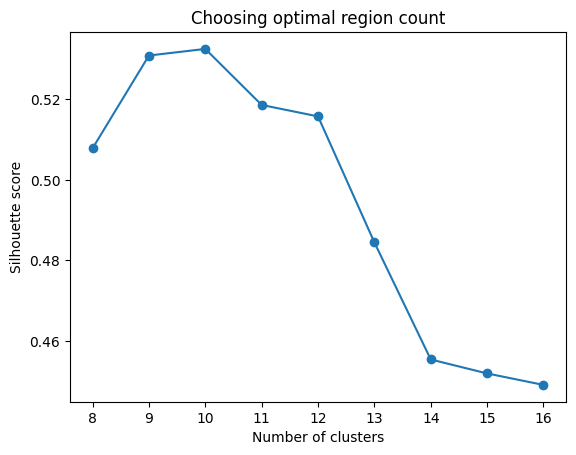

Best number of clusters: 10


In [ ]:
# 3. Try cluster counts from 8 to 16 (as recommended)
k_values = list(range(8, 17))
scores = silhouette_scores_by_k(coord_df, k_values)

# 4. Plot scores - visually select best (highest) value
plt.plot(k_values, scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Choosing optimal region count")
plt.show()

best_k = k_values[np.argmax(scores)]
print(f"Best number of clusters: {best_k}")

/tmp/ipython-input-2253011785.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Region_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']].fillna(method='ffill'))


KMeans model saved to kmeans_model.pkl
    Latitude  Longitude  Region_Cluster
0  18.784865  83.509019               1
1  18.967793  83.435006               1
2  18.314233  83.875563               1
3  18.270890  83.910681               1
4  18.331311  84.055088               1


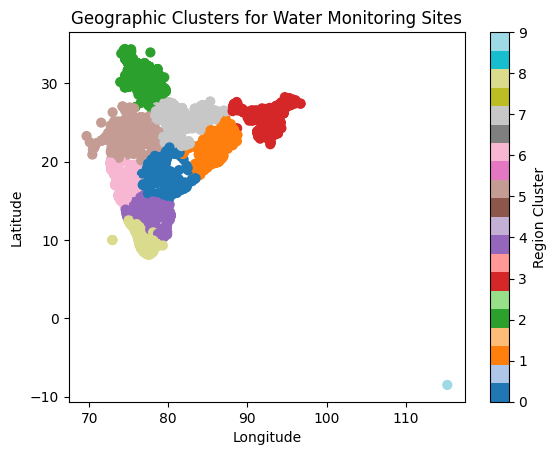

In [ ]:
# 6. Fit KMeans and assign region clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['Region_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']].fillna(method='ffill'))


joblib.dump(kmeans, "kmeans_model.pkl")
print("KMeans model saved to kmeans_model.pkl")

# 7. Inspect assignments (optional)
print(df[['Latitude', 'Longitude', 'Region_Cluster']].head())

# 8. Visualize clusters on scatter plot
plt.scatter(df['Longitude'], df['Latitude'], c=df['Region_Cluster'], cmap='tab20', s=40)
plt.colorbar(label="Region Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Clusters for Water Monitoring Sites")
plt.show()

In [ ]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Station Code                       3228 non-null   float64
 1   Monitoring Location                3229 non-null   object 
 2   State                              3228 non-null   object 
 3   Temperature (°C) Min               3060 non-null   float64
 4   Temperature (°C) Max               3060 non-null   float64
 5   Dissolved Oxygen(mg/L) Min         3166 non-null   float64
 6   Dissolved Oxygen(mg/L) Max         3166 non-null   float64
 7   pH Min                             3218 non-null   float64
 8   pH Max                             3218 non-null   float64
 9   Conductivity(µmho/cm) Min          2968 non-null   float64
 10  Conductivity(µmho/cm) Max          2968 non-null   object 
 11  BOD(mg/L) Min                      3190 non-null   float

In [ ]:
df.head()

,Station Code,Monitoring Location,State,Temperature (°C) Min,Temperature (°C) Max,Dissolved Oxygen(mg/L) Min,Dissolved Oxygen(mg/L) Max,pH Min,pH Max,Conductivity(µmho/cm) Min,...,Fecal Streptococci(MPN/100ml) Max,Type,full_address,Latitude,Longitude,Avg_Temp,Avg_Humidity,Avg_Wind,Weather_Main,Region_Cluster
0,1448.0,"River Nagavali At Thotapalli Regulator, Thotap...",Andhra Pradesh,24.0,34.0,5.7,7.3,7.0,8.4,219.0,...,3.0,NaN,"River Nagavali At Thotapalli Regulator, Thotap...",18.784865,83.509019,29.14,71.0,2.15,Clouds,1
1,4351.0,River Nagavali Immediate Border Between Andhra...,Andhra Pradesh,24.0,34.0,5.2,7.5,6.8,8.3,192.0,...,3.0,NaN,River Nagavali Immediate Border Between Andhra...,18.967793,83.435006,27.10,82.0,2.05,Clouds,1
2,4346.0,"River Nagavali Near Nh- 16 Bridge, Upstream (U...",Andhra Pradesh,24.0,37.0,5.8,7.6,6.4,8.4,289.0,...,3.0,NaN,"River Nagavali Near Nh- 16 Bridge, Upstream (U...",18.314233,83.875563,30.00,72.0,2.07,Clouds,1
3,4347.0,River Nagavali Near Water Pump House (Killipal...,Andhra Pradesh,24.0,37.0,5.4,8.0,6.3,8.5,275.0,...,3.0,NaN,River Nagavali Near Water Pump House (Killipal...,18.270890,83.910681,29.98,73.0,2.47,Clouds,1
4,2352.0,"River Vamsadhara, Gara (V & M)",Andhra Pradesh,20.0,36.0,5.2,8.2,7.1,8.3,165.0,...,3.0,NaN,"River Vamsadhara, Gara (V & M), Andhra Pradesh...",18.331311,84.055088,29.88,73.0,3.09,Clouds,1


In [ ]:
non_numeric_columns = ['Station Code', 'Monitoring Location', 'State', 'Type',
                       'full_address', 'Latitude', 'Longitude',
                       'Avg_Temp', 'Avg_Humidity', 'Avg_Wind', 'Weather_Main','Region_Cluster']

# Extract strictly numeric columns for processing
numeric_cols = [col for col in df.columns if col not in non_numeric_columns]
df_numeric = df[numeric_cols].copy()

In [ ]:
def clean_value(val):
    if isinstance(val, str):
        val = val.strip()
        if '\n' in val:
            val = val.split('\n')[0].strip()
        if val in ['-', '', 'NA', 'nan']:
            return np.nan
        try:
            return float(val)
        except:
            return np.nan
    return val

for col in df_numeric.columns:
    df_numeric[col] = df_numeric[col].apply(clean_value)

In [ ]:
# Convert all columns to numeric
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

In [ ]:
### --- Outlier Handling (IQR Method) --- ###
def remove_outliers_iqr(df, factor=1.5):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df.loc[:, col] = np.where((df[col] < lower) | (df[col] > upper), np.nan, df[col])  ##change made here

    return df

df_numeric = remove_outliers_iqr(df_numeric)

In [ ]:
imputer = SimpleImputer(strategy='mean')  # Using mean for numerical data
df_numeric.iloc[:, :] = imputer.fit_transform(df_numeric)


In [ ]:
# # Applying MinMax Scaling (scaling values between 0 and 1)
# scaler = MinMaxScaler()
# df_numeric.iloc[:, :] = scaler.fit_transform(df_numeric)

In [ ]:
df_processed = pd.concat([df[non_numeric_columns].reset_index(drop=True),
                          df_numeric.reset_index(drop=True)], axis=1)

In [ ]:
V_io = {
    'pH Min': 7.0, 'pH Max': 7.0,
    'Dissolved Oxygen(mg/L) Min': 14.6, 'Dissolved Oxygen(mg/L) Max': 14.6,
    'BOD(mg/L) Min': 0.0, 'BOD(mg/L) Max': 0.0,
    'Nitrate N(mg/L) Min': 0.0, 'Nitrate N(mg/L) Max': 0.0,
    'Fecal Coliform(MPN/100ml) Min': 0.0, 'Fecal Coliform(MPN/100ml) Max': 0.0,
    'Total Coliform(MPN/100ml) Min': 0.0, 'Total Coliform(MPN/100ml) Max': 0.0
}

S_n = {
    'pH Min': 8.5, 'pH Max': 8.5,
    'Dissolved Oxygen(mg/L) Min': 5.0, 'Dissolved Oxygen(mg/L) Max': 5.0,
    'BOD(mg/L) Min': 3.0, 'BOD(mg/L) Max': 3.0,
    'Nitrate N(mg/L) Min': 45.0, 'Nitrate N(mg/L) Max': 45.0,
    'Fecal Coliform(MPN/100ml) Min': 500.0, 'Fecal Coliform(MPN/100ml) Max': 500.0,
    'Total Coliform(MPN/100ml) Min': 5000.0, 'Total Coliform(MPN/100ml) Max': 5000.0
}

def calculate_qn(value, param):
    if param in V_io and param in S_n:
        # Protect against division by zero if V_io == S_n
        denominator = S_n[param] - V_io[param]
        if denominator == 0:
            return 0
        return 100 * ((value - V_io[param]) / denominator)
    return 0

# Calculate quality ratings Qn for each parameter (min and max)
df_qn = df_numeric.copy()
for col in S_n:
    df_qn[col] = df_qn[col].apply(lambda x: calculate_qn(x, col))

# Calculate weights (normalize such that sum of weights = 1)
weights_array = np.array([1 / S_n[param] for param in S_n])
K = 1 / weights_array.sum()
W_n = {param: K / S_n[param] for param in S_n}

# Calculate weighted quality ratings
df_weighted_qn = df_qn.copy()
for col in W_n:
    df_weighted_qn[col] = df_weighted_qn[col] * W_n[col]

# Compute WQI_Min using min parameters, WQI_Max using max parameters
min_cols = [col for col in W_n if 'Min' in col]
max_cols = [col for col in W_n if 'Max' in col]

df_weighted_qn['WQI_Min'] = df_weighted_qn[min_cols].sum(axis=1)
df_weighted_qn['WQI_Max'] = df_weighted_qn[max_cols].sum(axis=1)

# Calculate average WQI
df_weighted_qn['WQI_Average'] = df_weighted_qn[['WQI_Min', 'WQI_Max']].mean(axis=1)

# Add to final dataframe
df_processed['WQI_Min'] = df_weighted_qn['WQI_Min']
df_processed['WQI_Max'] = df_weighted_qn['WQI_Max']
df_processed['WQI_Average'] = df_weighted_qn['WQI_Average']

# Save output
output_path = '/content/Processed_WQuality.csv'
df_processed.to_csv(output_path, index=False)
print(f"✅ Saved cleaned data with calculated WQI_Min, WQI_Max, and WQI_Average to: {output_path}")

✅ Saved cleaned data with calculated WQI_Min, WQI_Max, and WQI_Average to: /content/Processed_WQuality.csv


In [ ]:
print(df.columns.tolist())


['Station Code', 'Monitoring Location', 'State', 'Temperature (°C) Min', 'Temperature (°C) Max', 'Dissolved Oxygen(mg/L) Min', 'Dissolved Oxygen(mg/L) Max', 'pH Min', 'pH Max', 'Conductivity(µmho/cm) Min', 'Conductivity(µmho/cm) Max', 'BOD(mg/L) Min', 'BOD(mg/L) Max', 'Nitrate N(mg/L) Min', 'Nitrate N(mg/L) Max', 'Fecal Coliform(MPN/100ml) Min', 'Fecal Coliform(MPN/100ml) Max', 'Total Coliform(MPN/100ml) Min', 'Total Coliform(MPN/100ml) Max', 'Fecal Streptococci(MPN/100ml) Min', 'Fecal Streptococci(MPN/100ml) Max', 'Type', 'full_address', 'Latitude', 'Longitude', 'Avg_Temp', 'Avg_Humidity', 'Avg_Wind', 'Weather_Main', 'Region_Cluster']


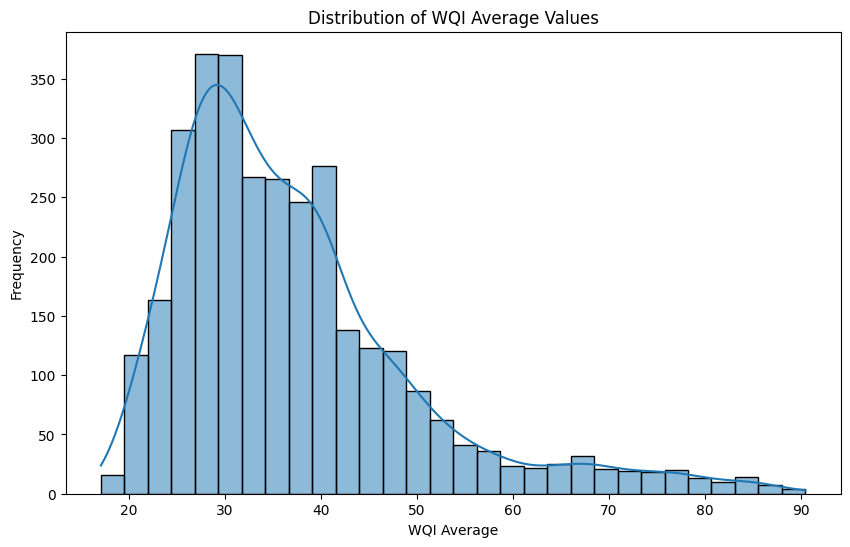

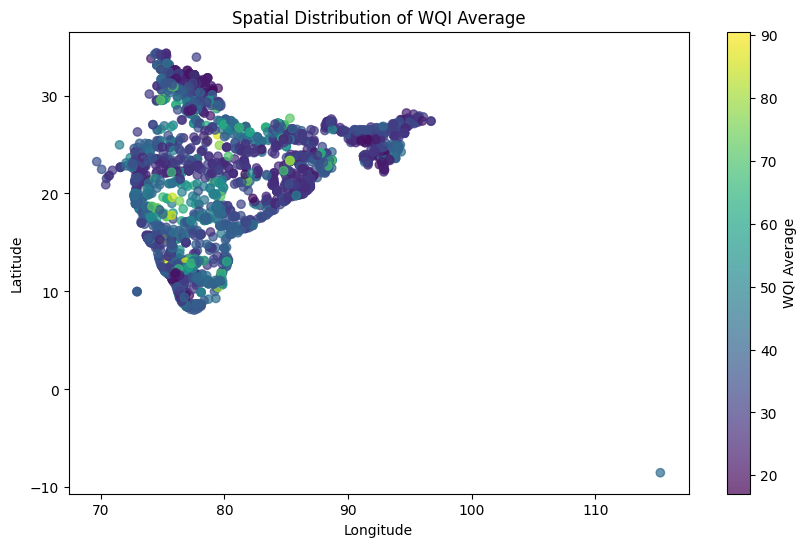

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['WQI_Average'], bins=30, kde=True)
plt.title('Distribution of WQI Average Values')
plt.xlabel('WQI Average')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of WQI Average across locations (assuming Latitude and Longitude are available)
plt.figure(figsize=(10, 6))
sc = plt.scatter(df_processed['Longitude'], df_processed['Latitude'],
                 c=df_processed['WQI_Average'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='WQI Average')
plt.title('Spatial Distribution of WQI Average')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

**ML MODEL RandomForestRegressor**

✅ Encoders saved to label_encoders.pkl

=== Train/Test Metrics ===
Train -> MSE: 0.240 | MAE: 0.335 | R^2: 0.999
Test  -> MSE: 1.648 | MAE: 0.872 | R^2: 0.990
OOB R^2: 0.989
[Hint] Test MSE > 1.25x Train MSE → Possible Overfitting.

=== Cross-Validation ===
CV R^2: mean 0.981 ± 0.004
CV RMSE: mean 1.541 ± 0.237


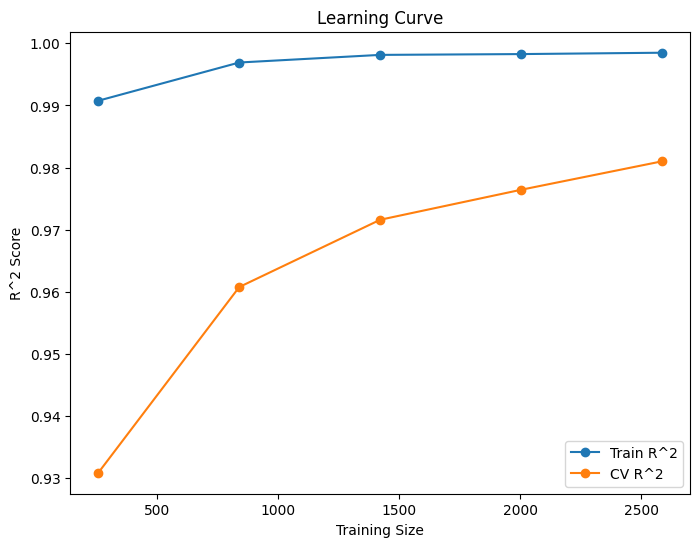


=== Top Features ===
BOD(mg/L) Max_weighted: 0.896183
BOD(mg/L) Min_weighted: 0.061200
Dissolved Oxygen(mg/L) Min_weighted: 0.007770
pH Max_weighted: 0.007603
Dissolved Oxygen(mg/L) Max_weighted: 0.006749
pH Min_weighted: 0.005812
Conductivity(µmho/cm) Min_weighted: 0.004209
Conductivity(µmho/cm) Max_weighted: 0.001605
Temperature (°C) Min_weighted: 0.001045
Avg_Temp_weighted: 0.001043
Avg_Humidity_weighted: 0.000984
Nitrate N(mg/L) Max_weighted: 0.000850
Temperature (°C) Max_weighted: 0.000581
State_weighted: 0.000571
Fecal Coliform(MPN/100ml) Max_weighted: 0.000543


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ----------------------------
# STEP 1: Load Data
# ----------------------------
data = pd.read_csv("/content/Processed_WQuality.csv")

# ----------------------------
# STEP 2: Assign Feature Weights
# ----------------------------
weights = {
    'BOD(mg/L) Max': 20,
    'BOD(mg/L) Min': 12,
    'Dissolved Oxygen(mg/L) Min': 10,
    'pH Min': 8,
    'pH Max': 7,
    'Dissolved Oxygen(mg/L) Max': 7,
    'Conductivity(µmho/cm) Min': 6,
    'Conductivity(µmho/cm) Max': 6,
    'Fecal Coliform(MPN/100ml) Max': 6,
    'Fecal Coliform(MPN/100ml) Min': 5,
    'Total Coliform(MPN/100ml) Max': 5,
    'Total Coliform(MPN/100ml) Min': 4,
    'Fecal Streptococci(MPN/100ml) Max': 4,
    'Fecal Streptococci(MPN/100ml) Min': 3,
    'Nitrate N(mg/L) Max': 5,
    'Nitrate N(mg/L) Min': 4,
    'Temperature (°C) Max': 5,
    'Temperature (°C) Min': 4,
    'Avg_Temp': 4,
    'Avg_Humidity': 3,
    'Avg_WindRegion_Cluster': 6,
    'Region_Cluster': 7,
    'Type': 7,
    'State': 3
}

# Normalize weights
total_weight = sum(weights.values())
normalized_weights = {k: v/total_weight for k, v in weights.items()}

# ----------------------------
# STEP 3: Encode Categoricals & Create Weighted Features
# ----------------------------
# Ensure categorical encoding
encoders = {}

for col in ['State', 'Type', 'Avg_WindRegion_Cluster', 'Region_Cluster']:
    if col in data.columns and data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        encoders[col] = le
with open('label_encoders_wqi.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print("✅ Encoders saved to label_encoders_wqi.pkl")

# Apply weights
for attr in normalized_weights:
    if attr in data.columns:
        data[f'{attr}_weighted'] = data[attr] * normalized_weights[attr]

# Final feature set
weighted_features = [f"{attr}_weighted" for attr in normalized_weights if f"{attr}_weighted" in data.columns]

# Define target
target = "WQI_Average"
X = data[weighted_features]
y = data[target]

# ----------------------------
# STEP 4: Train/Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# STEP 5: Train Random Forest
# ----------------------------
rf = RandomForestRegressor(
    n_estimators=500,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# ----------------------------
# STEP 6: Train/Test Metrics
# ----------------------------
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print("\n=== Train/Test Metrics ===")
print(f"Train -> MSE: {mean_squared_error(y_train, y_train_pred):.3f} | "
      f"MAE: {mean_absolute_error(y_train, y_train_pred):.3f} | "
      f"R^2: {r2_score(y_train, y_train_pred):.3f}")

print(f"Test  -> MSE: {mean_squared_error(y_test, y_test_pred):.3f} | "
      f"MAE: {mean_absolute_error(y_test, y_test_pred):.3f} | "
      f"R^2: {r2_score(y_test, y_test_pred):.3f}")

print(f"OOB R^2: {rf.oob_score_:.3f}")

# Overfitting check
if mean_squared_error(y_test, y_test_pred) > 1.25 * mean_squared_error(y_train, y_train_pred):
    print("[Hint] Test MSE > 1.25x Train MSE → Possible Overfitting.")

# ----------------------------
# STEP 7: Cross-Validation
# ----------------------------
cv_r2 = cross_val_score(rf, X, y, cv=5, scoring="r2", n_jobs=-1)
cv_rmse = np.sqrt(-cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1))

print("\n=== Cross-Validation ===")
print(f"CV R^2: mean {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
print(f"CV RMSE: mean {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")

# ----------------------------
# STEP 8: Learning Curve
# ----------------------------
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, scoring="r2", train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Train R^2")
plt.plot(train_sizes, test_mean, 'o-', label="CV R^2")
plt.xlabel("Training Size")
plt.ylabel("R^2 Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

# ----------------------------
# STEP 9: Feature Importance
# ----------------------------
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\n=== Top Features ===")
for i in sorted_idx[:15]:
    print(f"{X.columns[i]}: {importances[i]:.6f}")


In [ ]:
import joblib
joblib.dump(rf, "water_quality_model.pkl")

['water_quality_model.pkl']

In [ ]:
from google.colab import files
files.download("water_quality_model.pkl")  # replace with your filename


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pipeline

In [ ]:
# -----------------------------
# Load Models
# -----------------------------
wqi_model = joblib.load("water_quality_model.pkl")   # RandomForestRegressor
kmeans = joblib.load("kmeans_model.pkl")             # KMeans for region clustering

with open("label_encoders.pkl", "rb") as f:
    wqi_encoders = pickle.load(f)

# -----------------------------
# Normalized Weights (from training)
# -----------------------------
weights = {
    'BOD(mg/L) Max': 20,
    'BOD(mg/L) Min': 12,
    'Dissolved Oxygen(mg/L) Min': 10,
    'pH Min': 8,
    'pH Max': 7,
    'Dissolved Oxygen(mg/L) Max': 7,
    'Conductivity(µmho/cm) Min': 6,
    'Conductivity(µmho/cm) Max': 6,
    'Fecal Coliform(MPN/100ml) Max': 6,
    'Fecal Coliform(MPN/100ml) Min': 5,
    'Total Coliform(MPN/100ml) Max': 5,
    'Total Coliform(MPN/100ml) Min': 4,
    'Fecal Streptococci(MPN/100ml) Max': 4,
    'Fecal Streptococci(MPN/100ml) Min': 3,
    'Nitrate N(mg/L) Max': 5,
    'Nitrate N(mg/L) Min': 4,
    'Temperature (°C) Max': 5,
    'Temperature (°C) Min': 4,
    'Avg_Temp': 4,
    'Avg_Humidity': 3,
    'Avg_WindRegion_Cluster': 6,
    'Region_Cluster': 7,
    'Type': 7,
    'State': 3
}
total_weight = sum(weights.values())
normalized_weights = {k: v/total_weight for k, v in weights.items()}

# -----------------------------
# Preprocessing Function
# -----------------------------
def preprocess_wqi_input(user_input: dict):
    """
    Convert raw water sample + lat/lon into processed weighted features
    for WQI model.
    """
    processed = {}

    # 1. Assign Region_Cluster using KMeans
    if "Latitude" in user_input and "Longitude" in user_input:
        coords = pd.DataFrame(
            [[user_input["Latitude"], user_input["Longitude"]]],
            columns=["Latitude", "Longitude"]
        )
        region_cluster = int(kmeans.predict(coords)[0])
        user_input["Region_Cluster"] = region_cluster
    else:
        user_input["Region_Cluster"] = 0

    # 2. Encode categorical features with safe fallback
    for col, le in wqi_encoders.items():
        if col in user_input:
            val = str(user_input[col])
            if val in le.classes_:
                processed[col] = le.transform([val])[0]
            else:
                processed[col] = -1  # unseen category
        else:
            processed[col] = 0

    # 3. Apply weights to numeric + categorical features
    for attr, weight in normalized_weights.items():
        if attr in processed:
            val = processed[attr]  # already encoded categorical
        else:
            val = user_input.get(attr, 0)
            try:
                val = float(val)
            except:
                val = 0
        processed[f"{attr}_weighted"] = val * weight

    return processed

# -----------------------------
# Prediction Function
# -----------------------------
def predict_wqi(user_input: dict):
    """
    Predict WQI for a given raw water input dict (with Latitude/Longitude).
    """
    processed_input = preprocess_wqi_input(user_input)
    ordered_features = [f for f in wqi_model.feature_names_in_]
    feature_vector = np.array([[processed_input.get(f, 0) for f in ordered_features]])
    return wqi_model.predict(feature_vector)[0]

Predicted WQI: 39.41371308593897


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
sample = {
    "Latitude": 10.123,
    "Longitude": 76.456,
    "BOD(mg/L) Max": 3.1,
    "BOD(mg/L) Min": 2.8,
    "pH Min": 6.8,
    "pH Max": 7.4,
    "Dissolved Oxygen(mg/L) Min": 4.9,
    "Dissolved Oxygen(mg/L) Max": 5.8,
    "Nitrate N(mg/L) Min": 0.5,
    "Nitrate N(mg/L) Max": 0.7,
    "Fecal Coliform(MPN/100ml) Min": 100,
    "Fecal Coliform(MPN/100ml) Max": 300,
    "Total Coliform(MPN/100ml) Min": 2000,
    "Total Coliform(MPN/100ml) Max": 4000,
    "Fecal Streptococci(MPN/100ml) Min": 50,
    "Fecal Streptococci(MPN/100ml) Max": 100,
    "Temperature (°C) Min": 24,
    "Temperature (°C) Max": 29,
    "Avg_Temp": 27,
    "Avg_Humidity": 70,
    "Avg_WindRegion_Cluster": 2,
    "Type": "River",
    "State": "Kerala"
}

predicted_wqi = predict_wqi(sample)
print("Predicted WQI:", predicted_wqi)


Predicted WQI: 39.413713085938966


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
